make more flexible funcs  
error handling
Preprocessing eg https://github.com/DigitalBiomarkerDiscoveryPipeline/feature-engineering-and-extraction

In [51]:
### utility functions for converting

# Function 1: Load JSON

import json
import os

def load_ohm_json(filepath):
    """
    Load and parse an ohm JSON file with error handling.

    Args:
        filepath: path to the JSON file

    Returns:
        Parsed data (usually a list of entries), or None if failed
    """
    if not os.path.exists(filepath):
        print(f"Error: File not found: {filepath}")
        return None

    try:
        with open(filepath, "r") as file:
            data = json.load(file)
        if not isinstance(data, list):
            print("JSON content is not correct.")
        return data
    except json.JSONDecodeError as e:
        print("JSON decode error: {e}")
        return None


In [52]:

# Function 2: Extract measure records

import pandas as pd
from datetime import datetime


def extract_ohm_records(data, fields, timestamp_field="effective_time_frame"):

    """
    Extract records for any measure.

    Args:
        data: loaded JSON data
        fields: dict mapping your desired output column names to the path in `body`, e.g.,
                {"systolic": "systolic_blood_pressure.value", "diastolic": "diastolic_blood_pressure.value"}
        timestamp_field: path to timestamp, default "effective_time_frame"

    Returns:
        DataFrame with timestamp and specified fields
    """
    records = []

    for entry in data:
        try:
            # Find timestamp
            tf = entry["body"][timestamp_field]
            if "date_time" in tf:
                timestamp = tf["date_time"]
            elif "time_interval" in tf:
                timestamp = tf["time_interval"]["start_date_time"]
            else:
                print("unable to get timestamp")
                continue

            row = {"timestamp": datetime.fromisoformat(timestamp.replace("Z", "+00:00"))}

            # Extract specified fields
            for col_name, path in fields.items():
                value = entry["body"]
                for key in path.split("."):
                    value = value[key]
                row[col_name] = value

            records.append(row)
        except Exception:
            #print("unable to get entry")
            continue

    df = pd.DataFrame(records)
    
    if not df.empty:
        df.sort_values("timestamp", inplace=True)
        df.reset_index(drop=True, inplace=True)
    return df

In [53]:
# Function 3: Plot samples

import matplotlib.pyplot as plt

def plot_ohm_samples(df, value_columns=None, title="Measurement Samples", y_label="Value"):
    """
    General plot function for any measure DataFrame.

    Args:
        df: DataFrame with timestamp and value columns
        value_columns: list of column names to plot; if None, plot all except timestamp
        title: plot title
        y_label: y-axis label
    """
    if value_columns is None:
        value_columns = [col for col in df.columns if col != "timestamp"]

    plt.figure(figsize=(10, 5))

    for col in value_columns:
        plt.plot(df["timestamp"], df[col], label=col.capitalize(), marker='o', markersize=2, linewidth=1)

    plt.xlabel("Date")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [54]:
# Function 4: export to WFDB

import wfdb

def convert_ohm_to_wfdb(df, record_name="record", units=None, fs=1):
    """
    Convert any DataFrame to WFDB format.

    Args:
        df: DataFrame with 'timestamp' column and value columns
        record_name: output record name
        output_path: output folder path
        units: list of units for each value column (default 'a.u.')
        fs: sample rate (default 1 Hz)
    """
    # Use all columns except timestamp as signal columns
    value_columns = [col for col in df.columns if col != "timestamp"]

    if not value_columns:
        raise ValueError("No value columns found in DataFrame.")

    sig_data = df[value_columns].to_numpy()

    # Set default units if not provided
    if units is None:
        units = ["a.u."] * len(value_columns)

    comments = [f"timestamp: {ts.isoformat()}" for ts in df["timestamp"]]

    wfdb.wrsamp(
        record_name,
        fs=fs,
        units=units,
        sig_name=value_columns,
        p_signal=sig_data,
        comments=comments
    )


In [55]:
# Function 5: Plot WFDB record

import wfdb

def plot_wfdb_record(record_name, title=None, figsize=(10, 5)):
    """
    Plot a WFDB record.

    Args:
        record_name: base name of WFDB record (without .hea)
        record_path: directory containing WFDB files
        title: plot title (optional)
        figsize: figure size for plot
    """

    record = wfdb.rdrecord(record_name)

    if title is None:
        title = f"{record_name} (WFDB Format)"
    wfdb.plot_wfdb(record=record, title=title, figsize=figsize)


In [56]:
## https://github.com/DigitalBiomarkerDiscoveryPipeline/feature-engineering-and-extraction/blob/main/time_domain_features.py

from math import sqrt
from sklearn.metrics import mean_squared_error

import numpy as np
import scipy.stats as ss

def root_mean_square(data):
    """
    Calculates root mean squared value of a given data
    
    Parameters
    ----------
    data : array_like
        array of data to get root mean squared value from
        
    Returns:
    -------
    rms : float
        root mean squared value of the data
    """
    data = np.square(data)
    rms = sqrt(np.mean(data))
    return rms

def energy(data):
    """
    Calculate energy of a data set over a time domain
    
    Parameters
    ----------
    data : array like
        array of data need to get energy from
    
    Returns
    -------
    energy : float
        energy of time domain data
    """
    data = np.sum(np.square(np.abs(data)))
    return data

def average_power(data):
    """Function that calculates average power of an array of data

    Parameters
    ----------
    data : array like
        array of data of interest, to evaluate average power

    Returns
    -------
    avg_power : float
        numerical value of average power
    """
    num = len(data)
    data = energy(data)
    avg_power = data/num
    return avg_power

In [ ]:
# ref: https://github.com/DigitalBiomarkerDiscoveryPipeline/feature-engineering-and-extraction/blob/main/statistical_features.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

class Features:
    """
    Class containing methods that return statistical features of the data
    data : (arr) array of the data that need to get statistical features from
    """
    def __init__(self, data) -> None:
        self.data = data
    def get_skewness(self, bias=False):
        """
        Parameters
        ----------
        bias : (bool), whether bias is included in skewness
        
        Returns
        -------
        skewness value in float
        """
        return ss.skew(self.data, bias=bias)
    def get_kurtosis(self, bias=False):
        """
        Parameters
        ----------
        bias : (bool) whether bias is included in kurtosis
        
        Returns
        -------
        Kurtosis value in float
        """
        return ss.kurtosis(self.data, bias=bias)
    def summarize(self):
        """
        Returns
        -------
        Print all summary statistics of the data passed to __init__ function
        Summary statistics include: mean, median, standard deviation, mode, range, skewness, and kurtosis
        """
        mean = np.average(self.data)
        median = np.median(self.data)
        sd = np.std(self.data)
        mode = ss.mode(self.data)
        range = np.max(self.data) - np.min(self.data)
        print('Mean: ' + str(mean) + '\n' +
              'Median: ' + str(median) + '\n' +
              'Mode: ' + str(mode) + '\n' +
              'Range: ' + str(range) + '\n' +
              "Standard Deviation: " + str(sd) + '\n' +
              'Skewness: ' + str(self.get_skewness()) + '\n' +
              'Kurtosis: ' + str(self.get_kurtosis()) + '\n')

In [58]:
# utility funcs

def print_ohm_summary(data):
    """
    Print summary of ohm JSON data: list features and count samples.

    Args:
        data: loaded ohm JSON list
    """
    from collections import Counter

    if not data or not isinstance(data, list):
        print("No valid ohm data provided.")
        return

    # Count samples per schema name
    schema_counter = Counter()

    for entry in data:
        try:
            schema_name = entry["header"]["schema_id"]["name"]
            schema_counter[schema_name] += 1
        except KeyError:
            continue

    if not schema_counter:
        print("No schema names found in data.")
        return

    print("OHM Data Summary")
    print("==============================")
    for feature, count in schema_counter.items():
        print(f"Feature: {feature:30s} | Samples: {count}")
    print("==============================")




def summarize_omh_column(df, column_name):
    """
    Compute RMS, energy, and average power for a given OMH DataFrame column.

    Args:
        df: DataFrame with 'timestamp' and value columns.
        column_name: Name of the column to summarize.
    """
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return

    values = df[column_name].dropna().to_numpy()

    rms_val = root_mean_square(values)
    energy_val = energy(values)
    avg_power_val = average_power(values)

    print(f"  Summary for '{column_name}':")
    print(f"   - Root Mean Square (RMS): {rms_val:.4f}")
    print(f"   - Energy:               {energy_val:.4f}")
    print(f"   - Average Power:        {avg_power_val:.4f}")


def summarize_omh_column_with_features(df, column_name):
    """
    Summarizes a specified OMH DataFrame column using Features class.

    Args:
        df: DataFrame with OMH records.
        column_name: column to analyze.
    """
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame.")
        return

    values = df[column_name].dropna().to_numpy()

    # Use Features class
    feat = Features(values)
    feat.summarize()





In [59]:
# print ohm dataset 
data = load_ohm_json("1yr.json")
print_ohm_summary(data)


OHM Data Summary
Feature: blood-pressure                 | Samples: 350
Feature: body-weight                    | Samples: 378
Feature: step-count                     | Samples: 351
Feature: physical-activity              | Samples: 374
Feature: heart-rate                     | Samples: 363
Feature: minutes-moderate-activity      | Samples: 380


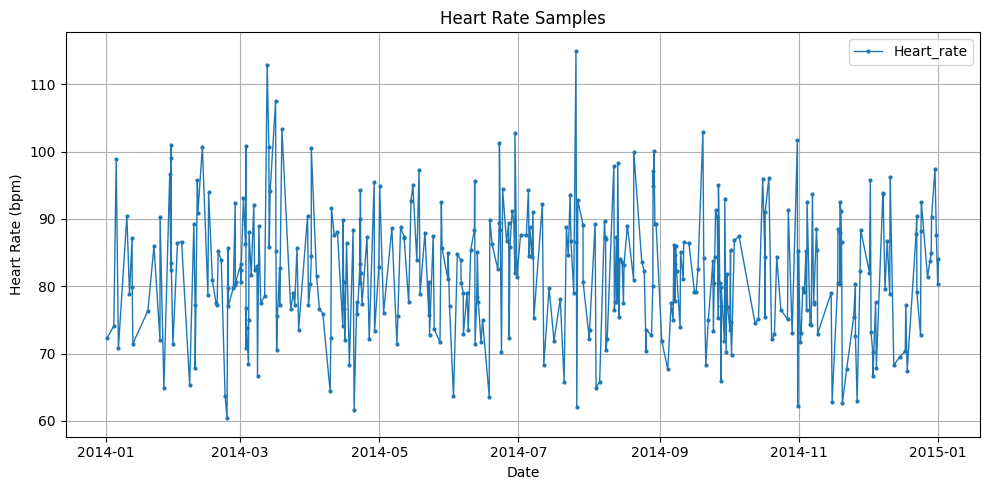

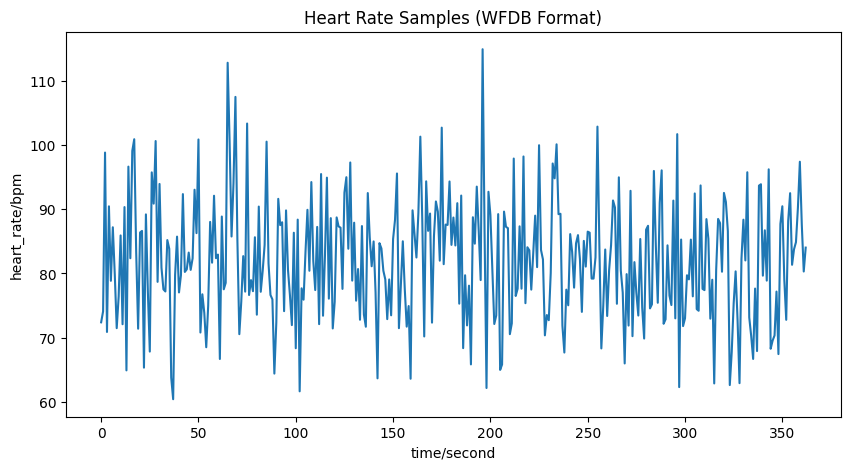

  Summary for 'heart_rate':
   - Root Mean Square (RMS): 82.5687
   - Energy:               2474788.1876
   - Average Power:        6817.5983
Mean: 82.02586621931974
Median: 81.76466596727286
Mode: ModeResult(mode=np.float64(60.38689157704969), count=np.int64(1))
Range: 54.58044425043473
Standard Deviation: 9.452808253023312
Skewness: 0.24354407004151946
Kurtosis: 0.009200403628630838



In [60]:
# Test case 1: plot heart rate

# load ohm file
data = load_ohm_json("./1yr.json")

# choose ohm feature: heart_rate
fields_hr = {
    "heart_rate": "heart_rate.value"
}

# extract ohm data to df
df_hr = extract_ohm_records(data, fields_hr)

# plot df
plot_ohm_samples(df_hr, title="Heart Rate Samples", y_label="Heart Rate (bpm)")

# convert df to wfdb
convert_ohm_to_wfdb(df_hr, record_name="heart_rate_1yr", units=["bpm"])

# plot wfdb
plot_wfdb_record(record_name = "heart_rate_1yr", title="Heart Rate Samples (WFDB Format)")

# get summary
summarize_omh_column(df_hr, "heart_rate")
summarize_omh_column_with_features(df_hr, "heart_rate")





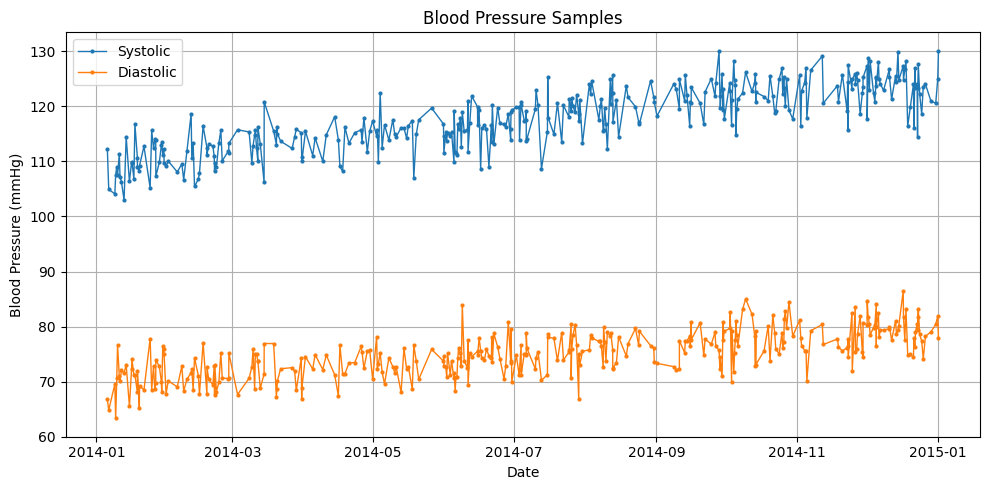

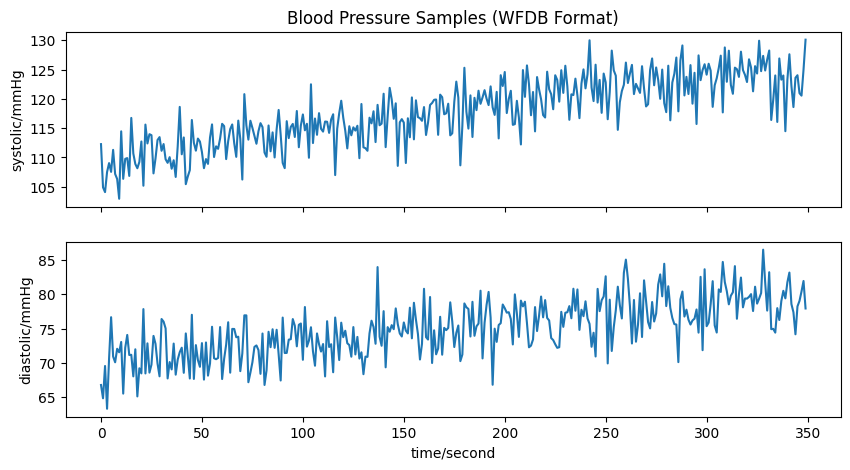

  Summary for 'systolic':
   - Root Mean Square (RMS): 117.8998
   - Energy:               4865124.1506
   - Average Power:        13900.3547
  Summary for 'diastolic':
   - Root Mean Square (RMS): 75.1184
   - Energy:               1974972.4102
   - Average Power:        5642.7783
Mean: 117.75870547056107
Median: 117.57188745693037
Mode: ModeResult(mode=np.float64(102.95952005647744), count=np.int64(1))
Range: 27.135670272335588
Standard Deviation: 5.765587735365637
Skewness: -0.13544050091535526
Kurtosis: -0.6984479139721951

Mean: 75.00470227781483
Median: 75.09671320685669
Mode: ModeResult(mode=np.float64(63.3359638921884), count=np.int64(1))
Range: 23.137005811207786
Standard Deviation: 4.13194275747479
Skewness: 0.008108615353505625
Kurtosis: -0.31238135850004634



In [61]:
# Test case 2: plot systolic and diastolic bp

# load ohm file
data = load_ohm_json("./1yr.json")

# choose ohm features: systolic and diastolic bp
fields_bp = {
    "systolic": "systolic_blood_pressure.value",
    "diastolic": "diastolic_blood_pressure.value"
}


# extract ohm data to df
df_bps = extract_ohm_records(data, fields_bp)

# plot df
plot_ohm_samples(df_bps, title="Blood Pressure Samples", y_label="Blood Pressure (mmHg)")

# convert df to wfdb
convert_ohm_to_wfdb(df_bps, record_name="bp_1yr", units=["mmHg", "mmHg"])

# plot wfdb
plot_wfdb_record(record_name = "bp_1yr", title="Blood Pressure Samples (WFDB Format)")

summarize_omh_column(df_bps, "systolic")
summarize_omh_column(df_bps, "diastolic")
summarize_omh_column_with_features(df_bps, "systolic")
summarize_omh_column_with_features(df_bps, "diastolic")
